# Photometric Stereo Hands On

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from pathlib import Path
import PIL
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  
from matplotlib import cm

In [25]:
from photometric_stereo import *
from photometric_stereo_utils import *

## 1.1 Estimating Albedo and Surface Normal
Let us start with the grayscale sphere model, which is located in the `SphereGray5` folder. The folder contains 5 images of a sphere with grayscale checker texture under similar lighting conditions with the one in the book. Your task is to estimate the surface reflectance (albedo) and surface normal of this model. The light source directions are encoded in the image file names.

In [9]:
# setting image directory

image_dir = '../photometrics_images/SphereGray5'

In [10]:
# loading grayscale images and light source directions from the image directory
# image_stack dimentions: height, width, number_of_images, number_of_channels
# scriptV dimentions: number_of_images, 3, number_of_channels

image_stack, scriptV = load_syn_images(image_dir, channels=(0,))

loading images...finished!
number of images:   5
image size:         (512, 512)
number of channels: 1
elapsed time: 0.68 s


In [11]:
# printing input data dimensions

h, w, n, n_ch = image_stack.shape

print(f'images height: {h:>14}', f'\nimages width: {w:>15}')
print(f'number of images:{n:>10}', f'\nnumber of channels: {n_ch:>7}')
print('-'*40)
print(f'image_stack dimensions: ', image_stack.shape)
print(f'scriptV dimensions:     ', scriptV.shape)

images height:            512 
images width:             512
number of images:         5 
number of channels:       1
----------------------------------------
image_stack dimensions:  (512, 512, 5, 1)
scriptV dimensions:      (5, 3)


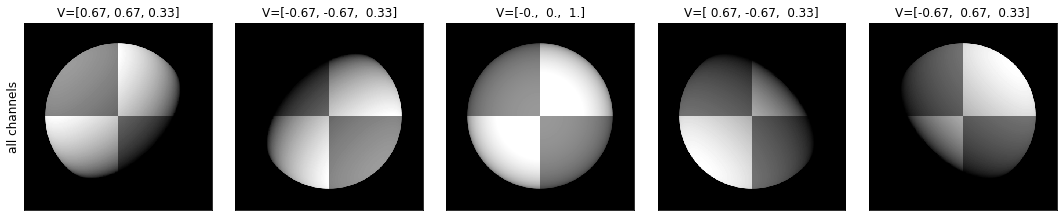

In [12]:
# displying some randomly sampled images

show_samples(image_stack, scriptV, n_samples=5, fig_size=3)

### Question - 1
1. Complete the code in `estimate_alb_norm` to estimate albedo and surface normal map for the `SphereGray5` folder. What do you expect to see in albedo image and how is it different with your result?

In [14]:
albedo, normals, _ = estimate_alb_norm(image_stack, scriptV, shadow_trick=True)

computing albedo and normals with shadow trick...finished!
elapsed time: 59.42 s


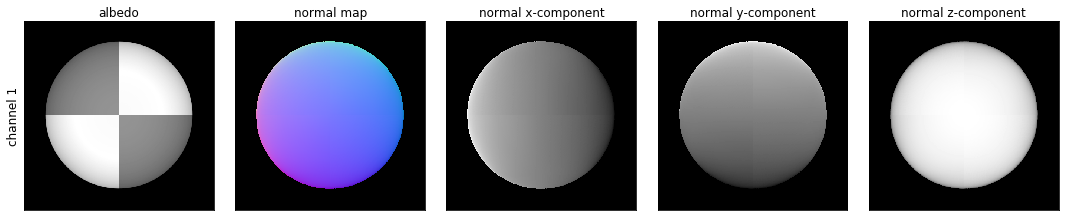

In [15]:
show_results(albedo, normals, fig_size=3)


2. In principle, what is the minimum number of images you need to estimate albedo and surface normal? Run the algorithm with more images by using `SphereGray25` and observe the differences in the results. You could try all images at once or a few at the time, in an incremental fashion. Choose a strategy and justify it by discussing your results.

loading images...finished!
number of images:   25
image size:         (512, 512)
number of channels: 1
elapsed time: 0.99 s
computing albedo and normals with shadow trick...finished!
elapsed time: 59.86 s


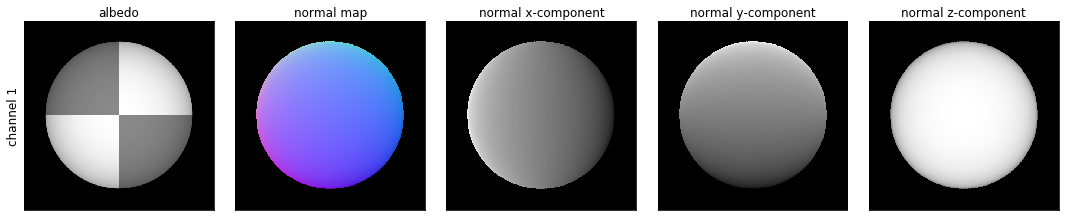

In [17]:
image_dir = '../photometrics_images/SphereGray25'
image_stack, scriptV = load_syn_images(image_dir, channels=(0,))
albedo, normals, _ = estimate_alb_norm(image_stack, scriptV, shadow_trick=True)
show_results(albedo, normals, fig_size=3)

In [18]:
# free up some memory

del image_stack, scriptV

3. What is the impact of shadows in photometric stereo? Explain the trick that is used in the text to deal with shadows. Remove that trick and check your results. Is the trick necessary in the case of 5 images, how about 25 images?

loading images...finished!
number of images:   5
image size:         (512, 512)
number of channels: 1
elapsed time: 0.09 s
computing albedo and normals without shadow trick...finished!
elapsed time: 0.48 s
computing albedo and normals with shadow trick...finished!
elapsed time: 59.27 s


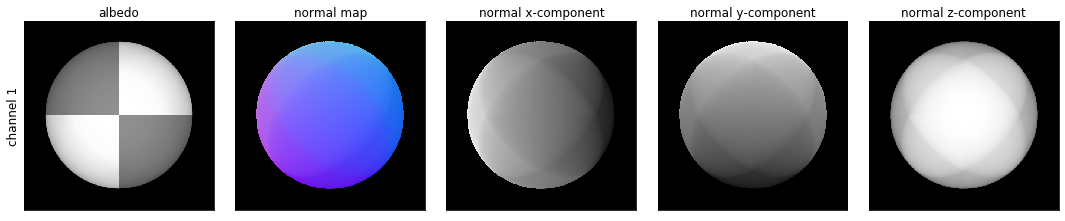

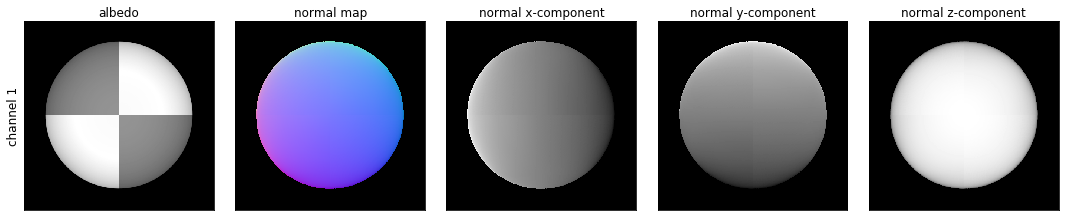

In [20]:
image_dir = '../photometrics_images/SphereGray5'

image_stack5, scriptV5 = load_syn_images(image_dir, channels=(0,))

# computing albedo and normals with and without shadow trick
albedo5, normals5, res5 = estimate_alb_norm(image_stack5, scriptV5, shadow_trick=False)
albedo5_st, normals5_st, res5_st = estimate_alb_norm(image_stack5, scriptV5, shadow_trick=True)

show_results(albedo5, normals5, fig_size=3)
show_results(albedo5_st, normals5_st, fig_size=3)

loading images...finished!
number of images:   25
image size:         (512, 512)
number of channels: 1
elapsed time: 0.68 s
computing albedo and normals without shadow trick...finished!
elapsed time: 0.42 s
computing albedo and normals with shadow trick...finished!
elapsed time: 68.81 s


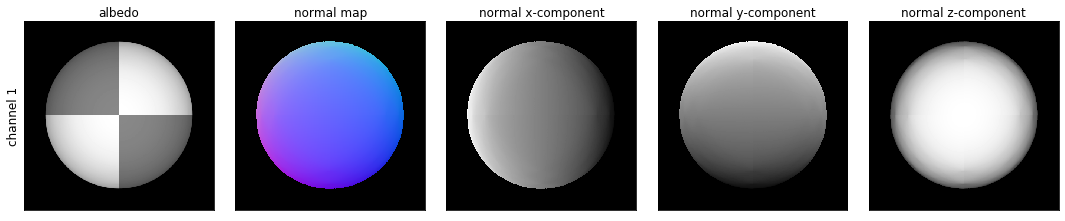

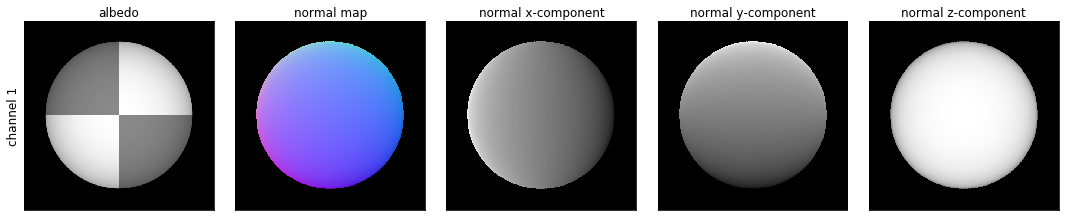

In [21]:
image_dir = '../photometrics_images/SphereGray25'

image_stack25, scriptV25 = load_syn_images(image_dir, channels=(0,))

# computing albedo and normals with and without shadow trick
albedo25, normals25, res25 = estimate_alb_norm(image_stack25, scriptV25, shadow_trick=False)
albedo25_st, normals25_st, res25_st = estimate_alb_norm(image_stack25, scriptV25, shadow_trick=True)

show_results(albedo25, normals25, fig_size=3)
show_results(albedo25_st, normals25_st, fig_size=3)

still better, but not much difference!

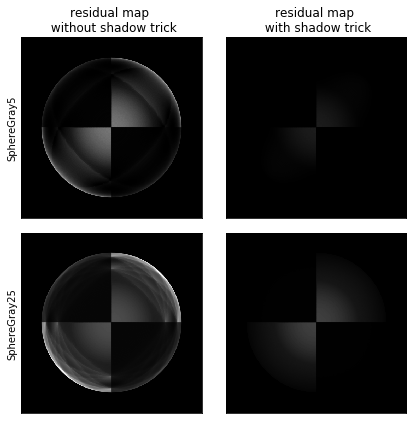

In [22]:
max_res = max(np.max(res5), np.max(res5_st), 
              np.max(res25/5), np.max(res25_st/25))

fig, axes = plt.subplots(2, 2, figsize=(6, 6), tight_layout=True)

for axs in axes:
    for ax in axs:
        ax.set(xticks=[], yticks=[])

axes[0, 0].imshow(res5.squeeze(), cmap='gray', vmax=max_res)
axes[0, 1].imshow(res5_st.squeeze(), cmap='gray', vmax=max_res)
axes[1, 0].imshow(res25.squeeze()/5, cmap='gray', vmax=max_res)
axes[1, 1].imshow(res25_st.squeeze()/5, cmap='gray', vmax=max_res)

axes[0, 0].set_title('residual map \n without shadow trick')
axes[0, 1].set_title('residual map \n with shadow trick')
axes[0, 0].set_ylabel('SphereGray5')
axes[1, 0].set_ylabel('SphereGray25');


## 1.2 Test of Integrability
Before we can reconstruct the surface height map, it is required to compute the partial derivatives $\frac{\partial f}{\partial x}$ and $\frac{\partial f}{\partial y}$ (or p and q in the algorithm). The partial derivatives also give us a chance to double check our computation, namely the test of ${\textit integrability}$.

### Question 2
1. Compute the partial derivatives (p and q in the algorithm) by filling in your code into `check_integrability`.
2. Implement and compute the second derivatives according to the algorithm and perform the test of integrability by choosing a reasonable threshold. What could be the reasons for the errors? How does the test perform with different number of images used in the reconstruction process in Question-1?

In [26]:
p, q, SE = check_integrability(normals5, nan_to_zero=True)
SE = np.nan_to_num(SE)

threshold:  0.005
----------------------------------------
number of outliers in channel 1:  1689
percentage of outliers in channel 1:  0.6%
----------------------------------------
elapsed time: 0.07 s


In [27]:

p, q, SE = check_integrability(normals5, threshold = 0.005, nan_to_zero=True)
SE = np.nan_to_num(SE)


p, q, SE = check_integrability(normals25, nan_to_zero=True)
SE = np.nan_to_num(SE)


threshold:  0.005
----------------------------------------
number of outliers in channel 1:  1689
percentage of outliers in channel 1:  0.6%
----------------------------------------
elapsed time: 0.08 s
threshold:  0.005
----------------------------------------
number of outliers in channel 1:  1614
percentage of outliers in channel 1:  0.6%
----------------------------------------
elapsed time: 0.13 s


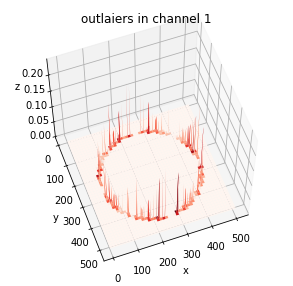

In [28]:
show_outlaiers(SE)

## 1.3 Shape by Integration 
To reconstruct the surface height map, we need to continuously integrate the partial derivatives over a path. However, as we are working with discrete structures, you will be simply summing their values. 
The algorithm in the chapter presents a way to do the integration in ${\textit column-major}$ order, that is you start at the top-left corner and integrate along the first column, then go towards right along each row. Yet, it is also noticed that it would be better to use many different paths and average so as to spread around the errors in the derivative estimates.

### Question - 3
1. Construct the surface height map using column-major order as described in the algorithm, then implement row-major path integration. Your code
should now go to construct surface.m. What are the differences in the results of the two paths?

integration in column-major order...
elapsed time: 0.03 s


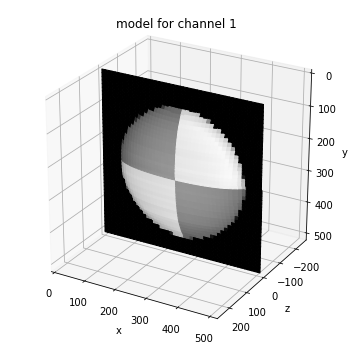

In [29]:
height_map_col = construct_surface(p, q, path_type='column')
show_model(height_map_col, albedo, fig_size=5)

integration in row-major order...
elapsed time: 0.04 s


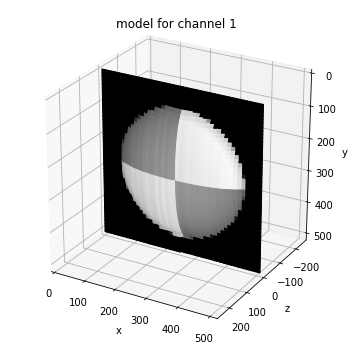

In [30]:
height_map_row = construct_surface(p, q, path_type='row')
show_model(height_map_row, albedo, fig_size=5)

2. Now, take the average of the results.Do you see any improvement compared to when using only one path? Are the construction results different with different number of images being used?

threshold:  0.005
----------------------------------------
number of outliers in channel 1:  1614
percentage of outliers in channel 1:  0.6%
----------------------------------------
elapsed time: 0.10 s
integration in column-major order...
elapsed time: 0.03 s
integration in row-major order...
elapsed time: 0.07 s
averaging...
elapsed time: 0.10 s


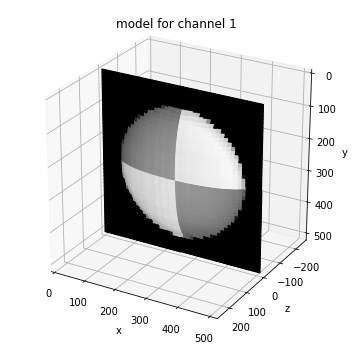

In [31]:
p, q, SE = check_integrability(normals25, nan_to_zero=True)
height_map = construct_surface(p, q, path_type='average')
show_model(height_map, albedo, fig_size=5)

threshold:  0.005
----------------------------------------
number of outliers in channel 1:  1689
percentage of outliers in channel 1:  0.6%
----------------------------------------
elapsed time: 0.08 s
integration in column-major order...
elapsed time: 0.02 s
integration in row-major order...
elapsed time: 0.04 s
averaging...
elapsed time: 0.09 s


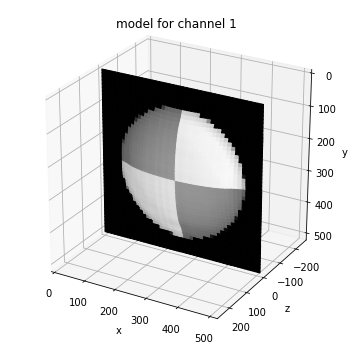

In [32]:
p, q, SE = check_integrability(normals5, nan_to_zero=True)
height_map = construct_surface(p, q, path_type='average')
show_model(height_map, albedo, fig_size=5)

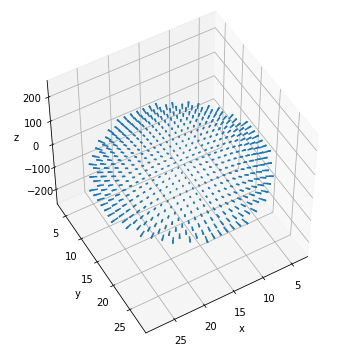

In [33]:
normals = normals25
show_normals(normals, height_map, sampling_step=16, fig_size=5, elev=50, azim=60)

In [34]:
del image_stack5, scriptV5, image_stack25, scriptV25

## 1.4 Experiments with different objects
In this part, you will try to run the photometric stereo algorithm in various number of scenarios to see how well it can be generalized.

### Question - 4
Run the algorithm and show the results for the `MonkeyGray` model. The albedo results of the monkey may comprise more albedo errors than in case of the sphere. Observe and describe the errors. What could be the reason for those errors? You may want to experiment with different number of images as you did in Question-1 to see the effects. How do you think that could help solving these errors?

loading images...finished!
number of images:   121
image size:         (512, 512)
number of channels: 1
elapsed time: 4.84 s


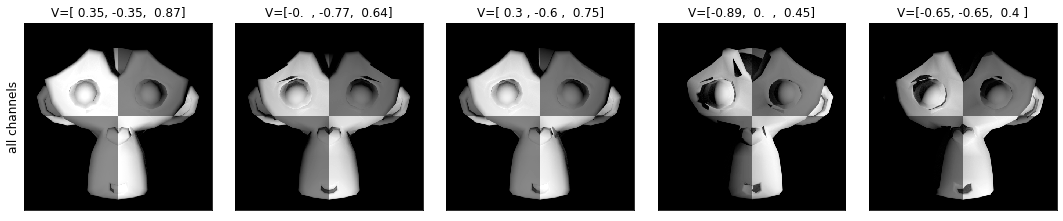

In [36]:
image_dir = '../photometrics_images/MonkeyGray'
image_stack, scriptV = load_syn_images(image_dir, channels=(0,))
show_samples(image_stack, scriptV, n_samples=5, fig_size=3)

computing albedo and normals without shadow trick...finished!
elapsed time: 0.45 s


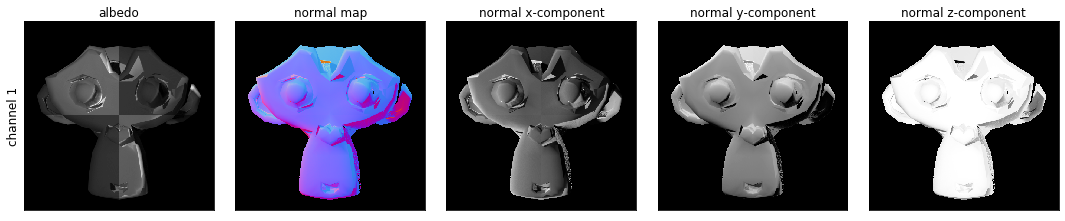

In [37]:
albedo, normals, _ = estimate_alb_norm(image_stack[:,:,:4,:], scriptV[:4,:])
show_results(albedo, normals, fig_size=3)

computing albedo and normals without shadow trick...finished!
elapsed time: 1.89 s


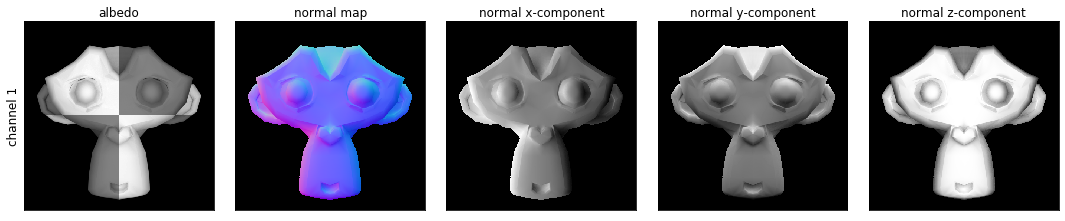

In [38]:
albedo, normals, _ = estimate_alb_norm(image_stack, scriptV)
show_results(albedo, normals, fig_size=3)

In [39]:
p, q, SE = check_integrability(normals, nan_to_zero=True)
SE = np.nan_to_num(SE)

threshold:  0.005
----------------------------------------
number of outliers in channel 1:  3626
percentage of outliers in channel 1:  1.4%
----------------------------------------
elapsed time: 0.19 s


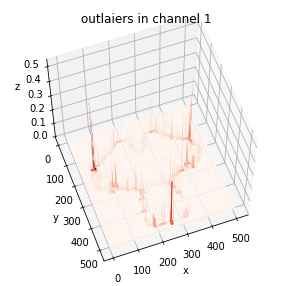

In [40]:
show_outlaiers(SE)

integration in column-major order...
elapsed time: 0.02 s
integration in row-major order...
elapsed time: 0.02 s
averaging...
elapsed time: 0.05 s


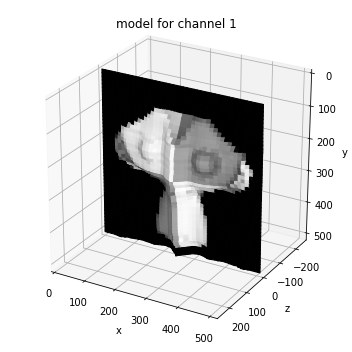

In [41]:
height_map = construct_surface(p, q, path_type='average')
show_model(height_map, albedo, fig_size=5)

In [42]:
del image_stack, scriptV

### Question - 5
Update the implementation to work for 3-channel **RGB** inputs and test it with 2 models `SphereColor` and `MonkeyColor`. Explain your changes and show your results. Observe the problem in the constructed surface normal map and height map, explain why a zero pixel could be a problem and propose a way to overcome that.

loading images...finished!
number of images:   25
image size:         (512, 512)
number of channels: 3
elapsed time: 1.59 s


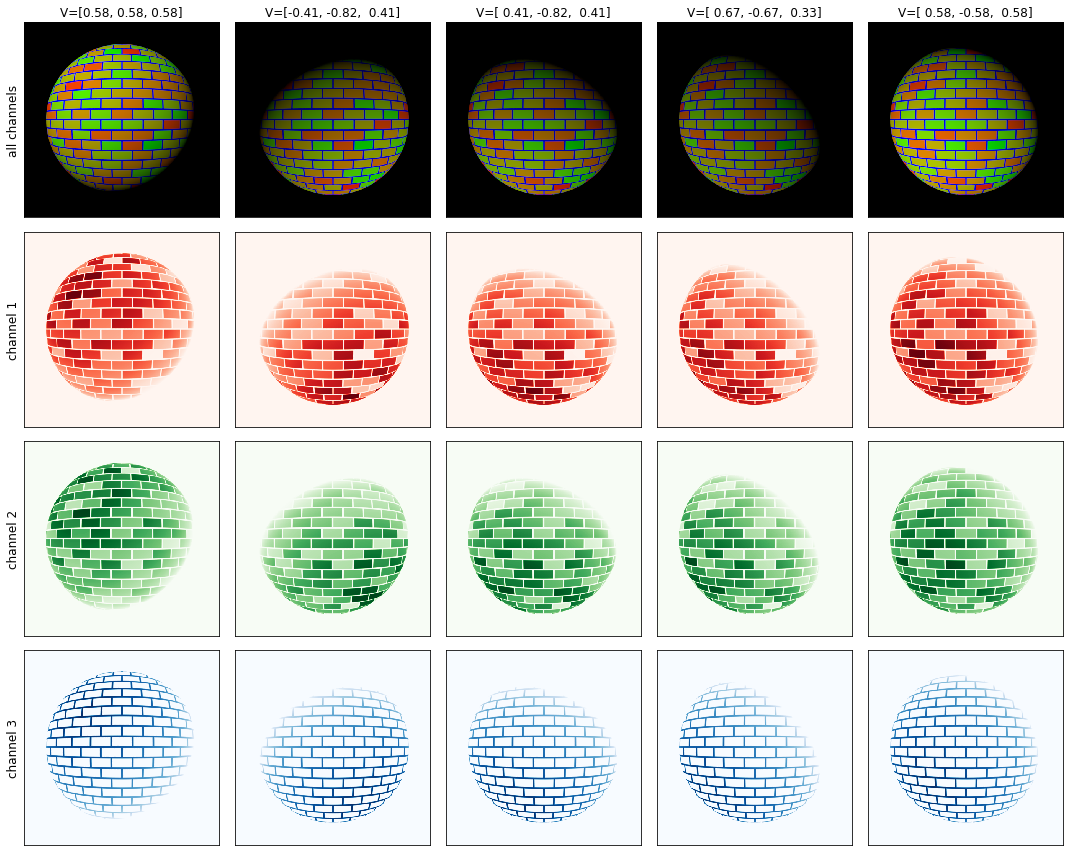

In [44]:
image_dir = '../photometrics_images/SphereColor'
image_stack, scriptV = load_syn_images(image_dir, channels=(0, 1, 2))
show_samples(image_stack, scriptV, n_samples=5, fig_size=3, show_channels=True)

computing albedo and normals without shadow trick...finished!
elapsed time: 3.22 s


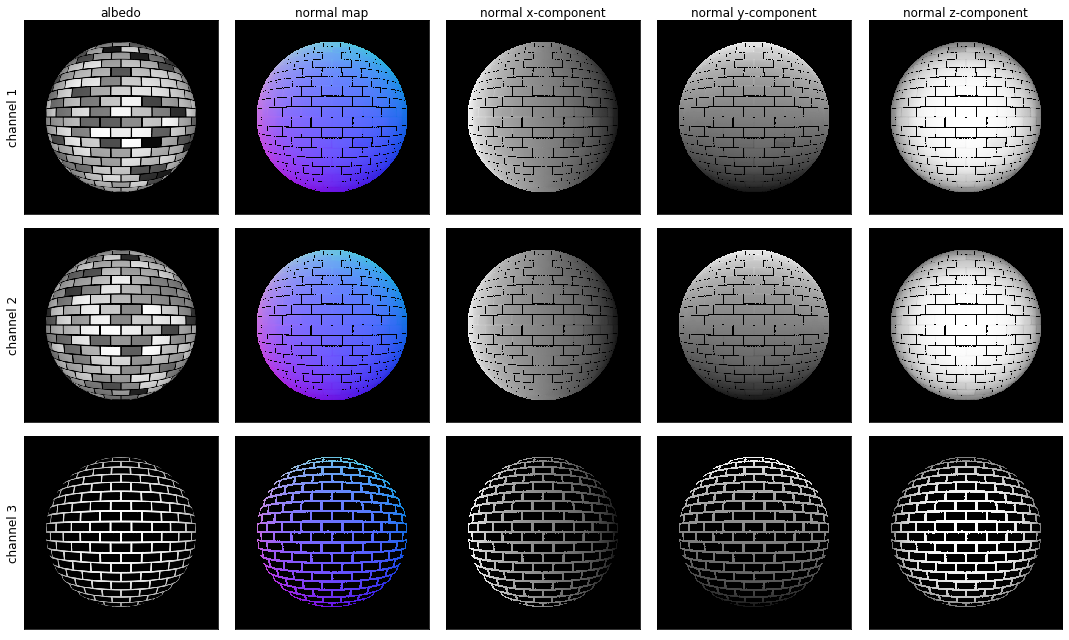

In [45]:
albedo, normals, _ = estimate_alb_norm(image_stack, scriptV)
show_results(albedo, normals, fig_size=3)

In [46]:
p, q, SE = check_integrability(normals, threshold=0.005, nan_to_zero=True)
SE = np.nan_to_num(SE)

threshold:  0.005
----------------------------------------
number of outliers in channel 1:  14513
percentage of outliers in channel 1:  5.5%
----------------------------------------
number of outliers in channel 2:  14175
percentage of outliers in channel 2:  5.4%
----------------------------------------
number of outliers in channel 3:  17013
percentage of outliers in channel 3:  6.5%
----------------------------------------
elapsed time: 0.26 s


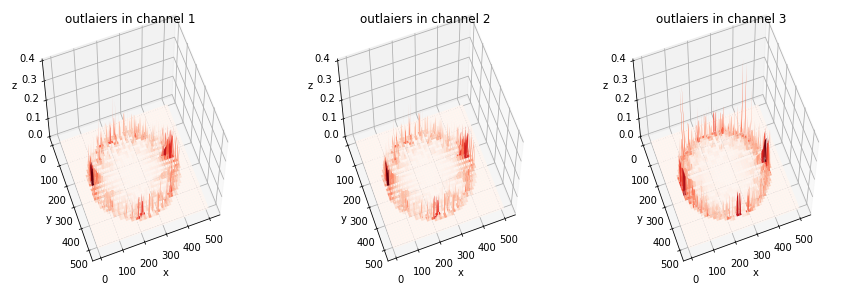

In [47]:
show_outlaiers(SE)

integration in column-major order...
elapsed time: 0.05 s
integration in row-major order...
elapsed time: 0.13 s
averaging...
elapsed time: 0.19 s


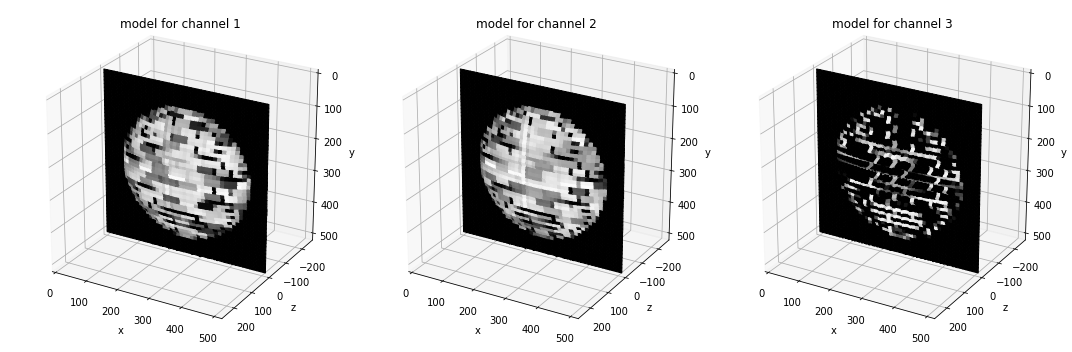

In [48]:
height_map = construct_surface(p, q, path_type='average')
show_model(height_map, albedo, fig_size=5)

In [49]:
image_stack = image_stack.mean(axis=3, keepdims=True)

computing albedo and normals without shadow trick...finished!
elapsed time: 0.66 s
threshold:  0.005
----------------------------------------
number of outliers in channel 1:  1623
percentage of outliers in channel 1:  0.6%
----------------------------------------
elapsed time: 0.04 s
integration in column-major order...
elapsed time: 0.01 s
integration in row-major order...
elapsed time: 0.01 s
averaging...
elapsed time: 0.03 s


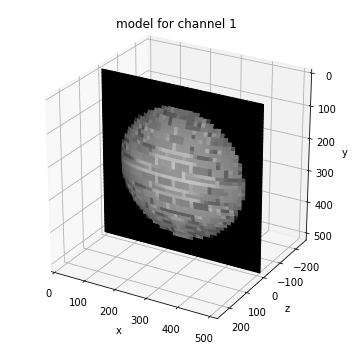

In [50]:
albedo, normals, _ = estimate_alb_norm(image_stack, scriptV)
p, q, SE = check_integrability(normals, nan_to_zero=True)
height_map = construct_surface(p, q, path_type='average')
show_model(height_map, albedo, fig_size=5)

In [51]:
del image_stack, scriptV

loading images...finished!
number of images:   121
image size:         (512, 512)
number of channels: 3
elapsed time: 10.14 s


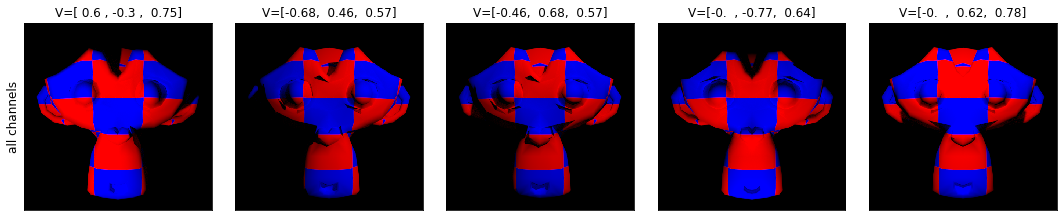

In [53]:
image_dir = '../photometrics_images/MonkeyColor'
image_stack, scriptV = load_syn_images(image_dir, channels=(0, 1, 2))
show_samples(image_stack, scriptV, n_samples=5, fig_size=3)

computing albedo and normals without shadow trick...finished!
elapsed time: 42.97 s


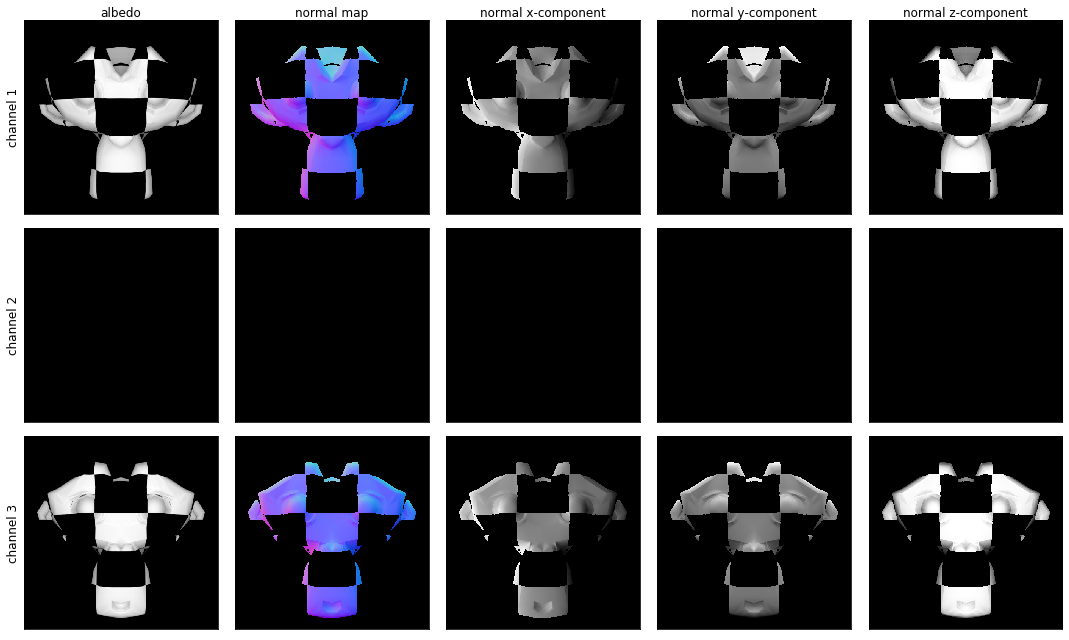

In [68]:
albedo, normals, _ = estimate_alb_norm(image_stack, scriptV)
show_results(albedo, normals, fig_size=3)

In [69]:
p, q, SE = check_integrability(normals, nan_to_zero=True)
SE = np.nan_to_num(SE)

_, _, n_ch = SE.shape

threshold = 0.005
print('threshold: ', threshold)
print('shadow trick: off')
print('-'*40)

for i in range(n_ch):
    n_outliers = np.sum(SE[:,:,i] > threshold)
    perc_outliers = 100 * n_outliers / (w*h)
    print(f'number of outliers in channel {i+1}: ', n_outliers)
    print(f'percentage of outliers in channel {i+1}: ', f'{perc_outliers:0.1f}%')
    print('-'*40)

elapsed time: 0.36 s
threshold:  0.005
shadow trick: off
----------------------------------------
number of outliers in channel 1:  4868
percentage of outliers in channel 1:  1.9%
----------------------------------------
number of outliers in channel 2:  0
percentage of outliers in channel 2:  0.0%
----------------------------------------
number of outliers in channel 3:  4248
percentage of outliers in channel 3:  1.6%
----------------------------------------


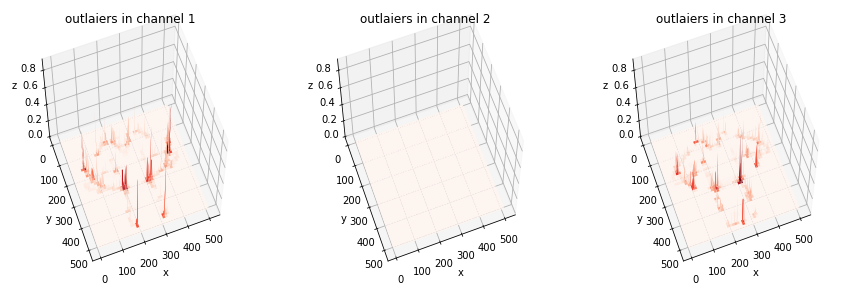

In [70]:
show_outlaiers(SE)

integration in column-major order...
elapsed time: 0.12 s
integration in row-major order...
elapsed time: 0.04 s
averaging...
elapsed time: 0.17 s


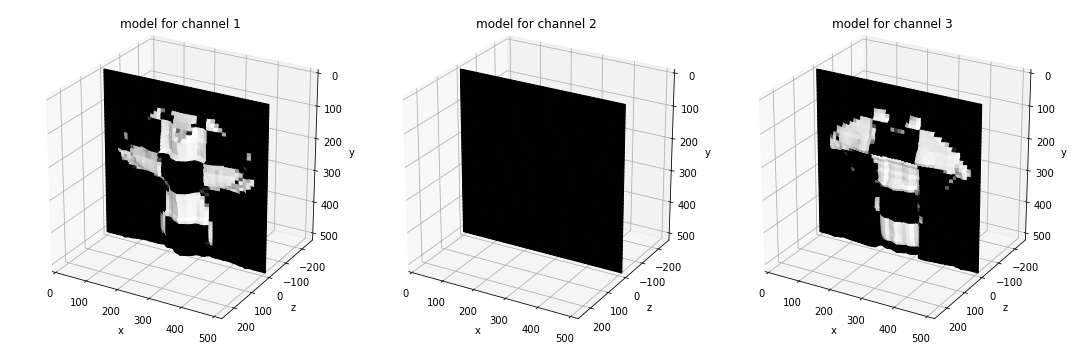

In [71]:
height_map = construct_surface(p, q, path_type='average')
show_model(height_map, albedo, fig_size=5)

In [73]:
image_stack = image_stack.mean(axis=3, keepdims=True)

computing albedo and normals without shadow trick...finished!
elapsed time: 2.12 s
elapsed time: 0.13 s
integration in column-major order...
elapsed time: 0.01 s
integration in row-major order...
elapsed time: 0.04 s
averaging...
elapsed time: 0.05 s


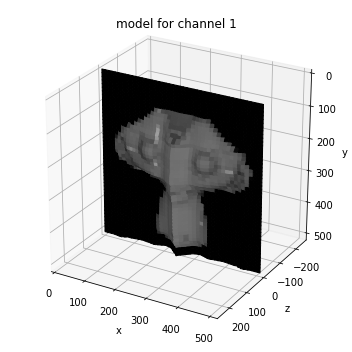

In [74]:
albedo, normals, _ = estimate_alb_norm(image_stack, scriptV)
p, q, SE = check_integrability(normals, nan_to_zero=True)
height_map = construct_surface(p, q, path_type='average')
show_model(height_map, albedo, fig_size=5, elev=25, azim=-60)

### Question - 6
Run the algorithm for the `Yale Face` images (included in the lab material). Observe and discuss the results for different integration paths. Discuss how the images violate the assumptions of the shape-from-shading methods. Remember to include specific input images to illustrate your points. How the results would improve when the problematic images are all removed? Show the results in your report.

In [54]:
del image_stack, scriptV

In [55]:
image_dir = '../photometrics_images/yaleB02'

In [56]:
image_stack, scriptV = load_face_images(image_dir)

loading images...finished!
number of images:   64
image size:         (192, 168)
number of channels: 1
elapsed time: 1.39 s


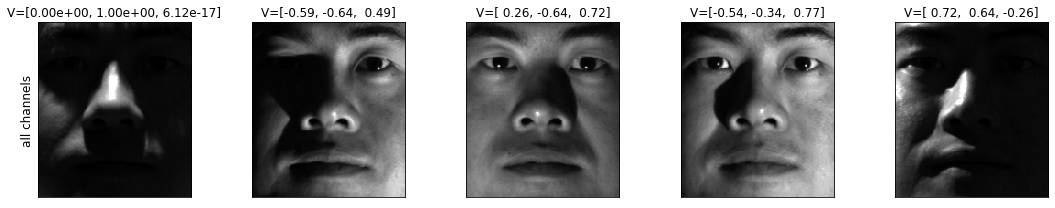

In [57]:
show_samples(image_stack, scriptV, n_samples=5, fig_size=3)

In [58]:
albedo, normals, _ = estimate_alb_norm(image_stack, scriptV)

computing albedo and normals without shadow trick...finished!
elapsed time: 0.27 s


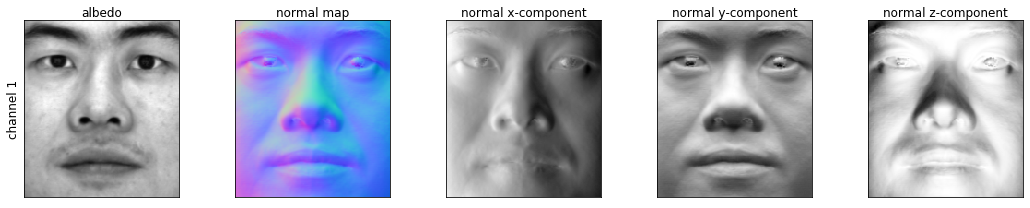

In [59]:
show_results(albedo, normals, fig_size=3, nan_to_zero=True)

In [61]:
p, q, SE = check_integrability(normals, nan_to_zero=True)
SE = np.nan_to_num(SE, nan=0.0)

threshold:  0.005
----------------------------------------
number of outliers in channel 1:  809
percentage of outliers in channel 1:  2.5%
----------------------------------------
elapsed time: 0.02 s


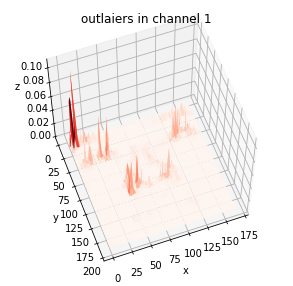

In [62]:
show_outlaiers(SE)

integration in column-major order...
elapsed time: 0.00 s
integration in row-major order...
elapsed time: 0.00 s
averaging...
elapsed time: 0.01 s


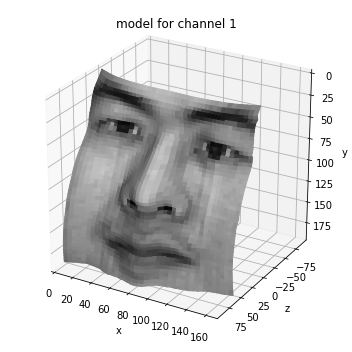

In [63]:
height_map = construct_surface(p, q, path_type='average')
show_model(height_map, albedo, fig_size=5, elev=25, azim=-60)